# First, we search for a stable reservoir

base spectral radius (before scaling) = 1.678684
rho=0.800 | exploded_run=False | lyapunov=-2.256081e-01 | final_norm=8.264e-63
rho=0.900 | exploded_run=False | lyapunov=-1.078251e-01 | final_norm=4.062e-32
rho=0.950 | exploded_run=False | lyapunov=-5.375786e-02 | final_norm=4.982e-18
rho=0.990 | exploded_run=False | lyapunov=-1.251490e-02 | final_norm=2.782e-07
rho=1.000 | exploded_run=False | lyapunov=-2.464563e-03 | final_norm=1.157e-04
rho=1.010 | exploded_run=False | lyapunov=7.485751e-03 | final_norm=4.523e-02
rho=1.050 | exploded_run=False | lyapunov=2.922169e-02 | final_norm=1.977e+00
rho=1.100 | exploded_run=False | lyapunov=3.041189e-02 | final_norm=2.713e+00


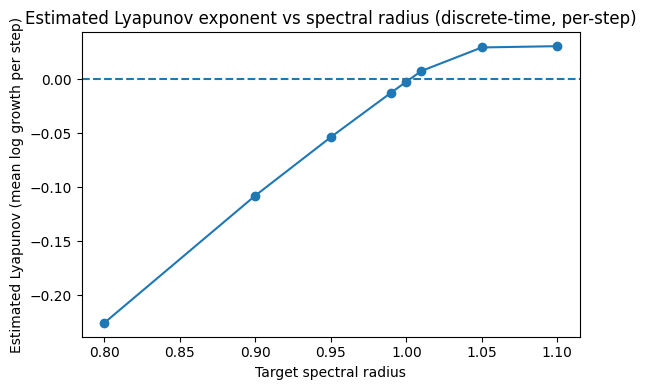

4


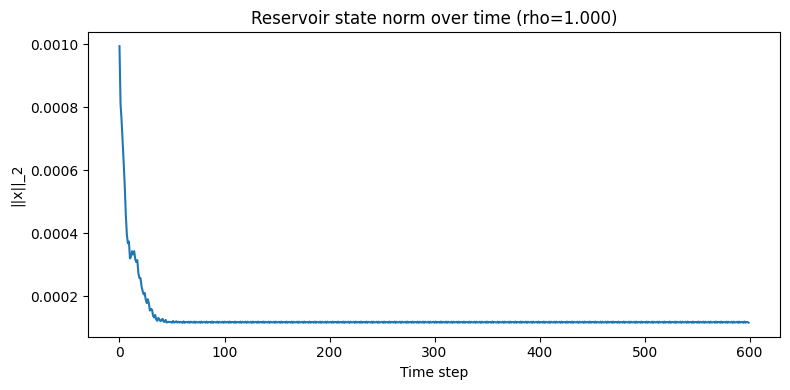

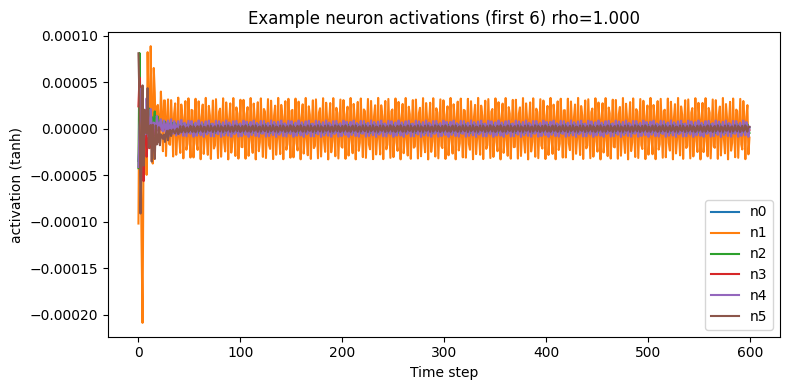

In [1]:
"""
Echo State Network (ESN) - edge-of-chaos exploration

What this does:
- Create a sparse reservoir W.
- Rescale W to target spectral radii near 1.0.
- Run autonomous dynamics x[t+1] = tanh(W x[t]) (no external input).
- Detect explosion if ||x|| grows past a large threshold.
- Estimate largest Lyapunov exponent by evolving two nearby trajectories.
- Plot Lyapunov vs spectral radius, reservoir norm over time, and a few neuron activations.

Dependencies:
    pip install numpy matplotlib
(Optional, faster spectral radius for large N):
    pip install scipy
"""

import numpy as np
import matplotlib.pyplot as plt

# ----------------------
# Utilities
# ----------------------

def make_sparse_reservoir(N, density=0.02, scale=1.0, random_state=None):
    """
    Create a sparse reservoir matrix with Gaussian weights on a Bernoulli mask.
    - N: reservoir size
    - density: fraction of nonzero connections (0..1)
    - scale: multiply entire matrix by this factor (useful for initial scaling)
    - random_state: integer seed or None
    """
    rng = np.random.RandomState(random_state)
    mask = rng.rand(N, N) < density
    W = rng.randn(N, N) * mask
    # fix any all-zero rows for numerical stability
    row_sums = np.abs(W).sum(axis=1)
    zero_rows = np.where(row_sums == 0)[0]
    for r in zero_rows:
        j = rng.randint(0, N)
        W[r, j] = rng.randn()
    W *= scale
    return W

def spectral_radius_numpy(W):
    """Compute spectral radius (largest absolute eigenvalue) via numpy.linalg.eigvals.
    For large N, consider using scipy.sparse.linalg.eigs on a sparse matrix (not included here)."""
    vals = np.linalg.eigvals(W)
    return np.max(np.abs(vals))

def rescale_to_spectral_radius(W, target_rho):
    """Scale matrix W so its spectral radius == target_rho."""
    sr = spectral_radius_numpy(W)
    if sr == 0:
        return W
    return W * (target_rho / sr)

# ----------------------
# Dynamics, explosion check, Lyapunov estimate
# ----------------------

def run_autonomous(W, x0, steps=1000, explosion_threshold=1e6):
    """
    Run autonomous dynamics x <- tanh(W x).
    Returns:
      xs: array (T, N) of states (or until explosion)
      exploded: bool
    """
    N = W.shape[0]
    xs = np.zeros((steps, N))
    x = x0.copy()
    exploded = False
    for t in range(steps):
        x = np.tanh(W @ x)
        xs[t] = x
        norm = np.linalg.norm(x)
        if np.isnan(norm) or np.isinf(norm) or norm > explosion_threshold:
            exploded = True
            return xs[:t+1], True
    return xs, False

def estimate_lyapunov_two_trajectories(W, x0, perturb=1e-8, steps=500, renormalize_every=1):
    """
    Estimate largest Lyapunov exponent using two nearby trajectories (Benettin-style).
    - x and y start close (distance ~ perturb). Evolve both, measure distance growth.
    - optionally renormalize the difference every renormalize_every steps.
    Returns:
      lyap_estimate (per step discrete-time; >0 indicates exponential divergence),
      exploded (True if numerical explosion encountered)
    """
    N = W.shape[0]
    rng = np.random.RandomState(0)
    x = x0.copy()
    y = x0.copy() + rng.randn(N) * perturb
    d = np.linalg.norm(y - x)
    if d == 0:
        y += perturb * np.ones_like(x)
        d = np.linalg.norm(y - x)

    logs = []
    for t in range(steps):
        x = np.tanh(W @ x)
        y = np.tanh(W @ y)
        d_new = np.linalg.norm(y - x)
        if np.isnan(d_new) or np.isinf(d_new) or d_new > 1e12:
            return float('nan'), True
        # prevent div-by-zero:
        logs.append(np.log((d_new + 1e-16) / (d + 1e-16)))
        # renormalize to keep separation small and in linear regime
        if (t + 1) % renormalize_every == 0 and d_new != 0:
            y = x + (y - x) * (perturb / d_new)
            d = np.linalg.norm(y - x)
        else:
            d = d_new
    lyap = np.mean(logs)  # per-step discrete-time Lyapunov estimate
    return lyap, False

# ----------------------
# Example experiment: sweep a list of spectral radii around 1.0
# ----------------------

def experiment_and_plot(
        N=200,
        density=0.02,
        spectral_radii=None,
        sim_steps=800,
        lyap_steps=400,
        explosion_threshold=1e6,
        random_state=42):
    """
    Build one base random reservoir and for each target spectral radius:
      - scale reservoir
      - run autonomous dynamics
      - estimate Lyapunov
      - record explosion/decay and final norm
    Then plot lyapunov vs spectral radius and show time series for the radius closest to 1.
    """
    if spectral_radii is None:
        spectral_radii = np.array([0.8, 0.9, 0.95, 0.99, 1.0, 1.01, 1.05, 1.1])

    # Build base reservoir once (so only the scaling changes)
    base_W = make_sparse_reservoir(N, density=density, random_state=random_state)
    base_sr = spectral_radius_numpy(base_W)
    print(f"base spectral radius (before scaling) = {base_sr:.6f}")

    results = []
    for rho in spectral_radii:
        # Fast rescale: scale factor = rho / base_sr
        W = base_W * (rho / base_sr)
        x0 = np.random.RandomState(random_state + 1).randn(N) * 1e-4  # small random start
        xs, exploded = run_autonomous(W, x0, steps=sim_steps, explosion_threshold=explosion_threshold)
        lyap, lyap_exploded = estimate_lyapunov_two_trajectories(W, x0, perturb=1e-8, steps=lyap_steps)
        final_norm = np.linalg.norm(xs[-1])
        results.append({
            "rho": rho,
            "exploded_run": exploded,
            "lyapunov": lyap,
            "lyap_exploded": lyap_exploded,
            "final_norm": final_norm,
            "states": xs
        })
        print(f"rho={rho:.3f} | exploded_run={exploded} | lyapunov={lyap:.6e} | final_norm={final_norm:.3e}")

    # Plot Lyapunov vs rho
    rhos = np.array([r["rho"] for r in results])
    lyaps = np.array([r["lyapunov"] for r in results])
    plt.figure(figsize=(6,4))
    plt.plot(rhos, lyaps, marker='o')
    plt.axhline(0, linestyle='--')
    plt.title("Estimated Lyapunov exponent vs spectral radius (discrete-time, per-step)")
    plt.xlabel("Target spectral radius")
    plt.ylabel("Estimated Lyapunov (mean log growth per step)")
    plt.tight_layout()
    plt.show()

    # pick the rho closest to 1.0 for time-series plots
    idx_closest = np.argmin(np.abs(rhos - 1.0))
    print(idx_closest)
    chosen = results[idx_closest]
    xs_chosen = chosen["states"]
    T = xs_chosen.shape[0]
    times = np.arange(T)

    # Plot reservoir norm over time
    norms = np.linalg.norm(xs_chosen, axis=1)
    plt.figure(figsize=(8,4))
    plt.plot(times, norms)
    plt.title(f"Reservoir state norm over time (rho={chosen['rho']:.3f})")
    plt.xlabel("Time step")
    plt.ylabel("||x||_2")
    plt.tight_layout()
    plt.show()

    # Plot first few neuron activations
    num_neurons_plot = min(6, xs_chosen.shape[1])
    plt.figure(figsize=(8,4))
    for i in range(num_neurons_plot):
        plt.plot(times, xs_chosen[:, i], label=f"n{i}")
    plt.title(f"Example neuron activations (first {num_neurons_plot}) rho={chosen['rho']:.3f}")
    plt.xlabel("Time step")
    plt.ylabel("activation (tanh)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # return results dict for further analysis if wanted
    return results

# ----------------------
# If script is executed directly, run a demonstration experiment
# ----------------------
if __name__ == "__main__":
    # Example: smaller reservoir for quick experimentation
    results = experiment_and_plot(
        N=150,                # try larger N (200-1000) for more realistic reservoirs, but longer runtime
        density=0.02,         # sparse connectivity
        spectral_radii=np.array([0.8, 0.9, 0.95, 0.99, 1.0, 1.01, 1.05, 1.1]),
        sim_steps=600,
        lyap_steps=300,
        explosion_threshold=1e6,
        random_state=12345
    )


# Second step: see how the reservoir respond to inputs

base spectral radius (before scaling) = 1.678684
rho=1.003 | exploded_run=False | lyapunov=5.309455e-04 | final_norm=4.348e+00


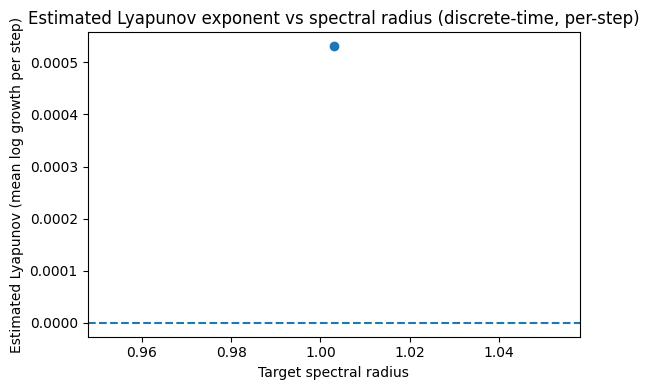

1.003


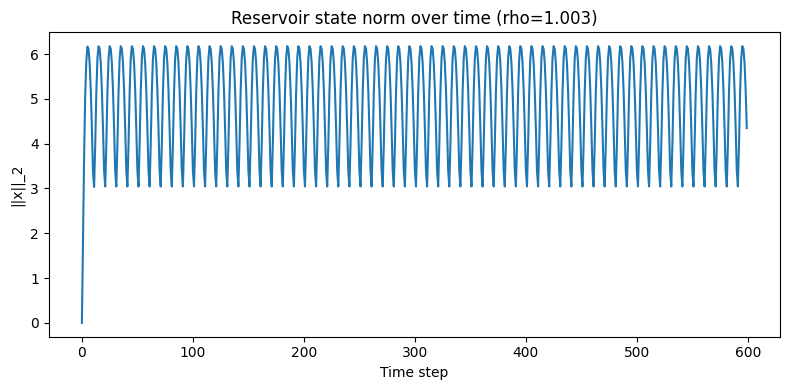

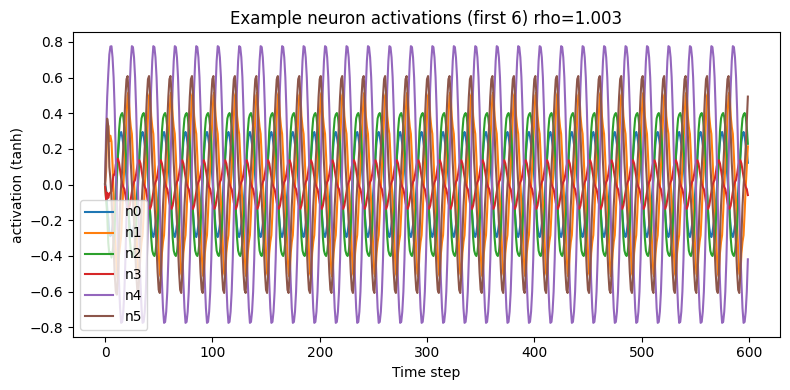

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def generate_sine_input(T, freq=0.05, amplitude=1.0):
    """Generate a sine wave input of length T."""
    return amplitude * np.sin(2 * np.pi * freq * np.arange(T))

def make_input_weights(N, input_dim, scale=1.0, random_state=None):
    """Create random input weights (N x input_dim)."""
    rng = np.random.RandomState(random_state)
    return rng.randn(N, input_dim) * scale

def run_with_input(W, W_in, x0, inputs, steps=None, explosion_threshold=1e6):
    """
    Run reservoir with external inputs.
    - W: reservoir matrix (N x N)
    - W_in: input weights (N x input_dim)
    - x0: initial state (N,)
    - inputs: array (T, input_dim) of input vectors
    - steps: if None, use all inputs; else, run for `steps` time steps
    Returns:
      xs: array (T, N) of states
      exploded: bool
    """
    N = W.shape[0]
    if steps is None:
        steps = inputs.shape[0]
    T = steps
    xs = np.zeros((T, N))
    x = x0.copy()
    exploded = False
    for t in range(T):
        u = inputs[t] if t < inputs.shape[0] else np.zeros(W_in.shape[1])
        x = np.tanh(W @ x + W_in @ u)
        xs[t] = x
        norm = np.linalg.norm(x)
        if np.isnan(norm) or np.isinf(norm) or norm > explosion_threshold:
            exploded = True
            return xs[:t+1], True
    return xs, False


def experiment_and_plot_with_input(
        N=200,
        input_dim=1,
        density=0.02,
        spectral_radii=None,
        sim_steps=800,
        lyap_steps=400,
        explosion_threshold=1e6,
        random_state=42):
    """
    Build one base random reservoir and for each target spectral radius:
      - scale reservoir
      - run autonomous dynamics
      - estimate Lyapunov
      - record explosion/decay and final norm
    Then plot lyapunov vs spectral radius and show time series for the radius closest to 1.
    """
    if spectral_radii is None:
        spectral_radii = np.array([0.999, 1.0, 1.001, 1.005, 1.01, 1.02, 1.03])

    # Build base reservoir once (so only the scaling changes)
    base_W = make_sparse_reservoir(N, density=density, random_state=random_state)
    base_sr = spectral_radius_numpy(base_W)
    print(f"base spectral radius (before scaling) = {base_sr:.6f}")

    W_in = make_input_weights(N, input_dim, scale=0.5, random_state=random_state)

    results = []
    for rho in spectral_radii:
        # Fast rescale: scale factor = rho / base_sr
        W = base_W * (rho / base_sr)
        x0 = np.random.RandomState(random_state + 1).randn(N) * 1e-4  # small random start
        
        inputs = generate_sine_input(sim_steps).reshape(-1, input_dim)

        xs, exploded = run_with_input(W, W_in, x0, inputs, steps=sim_steps, explosion_threshold=explosion_threshold)
        lyap, lyap_exploded = estimate_lyapunov_two_trajectories(W, x0, perturb=1e-8, steps=lyap_steps)
        final_norm = np.linalg.norm(xs[-1])
        results.append({
            "rho": rho,
            "exploded_run": exploded,
            "lyapunov": lyap,
            "lyap_exploded": lyap_exploded,
            "final_norm": final_norm,
            "states": xs
        })
        print(f"rho={rho:.3f} | exploded_run={exploded} | lyapunov={lyap:.6e} | final_norm={final_norm:.3e}")

    # Plot Lyapunov vs rho
    rhos = np.array([r["rho"] for r in results])
    lyaps = np.array([r["lyapunov"] for r in results])
    plt.figure(figsize=(6,4))
    plt.plot(rhos, lyaps, marker='o')
    plt.axhline(0, linestyle='--')
    plt.title("Estimated Lyapunov exponent vs spectral radius (discrete-time, per-step)")
    plt.xlabel("Target spectral radius")
    plt.ylabel("Estimated Lyapunov (mean log growth per step)")
    plt.tight_layout()
    plt.show()

    # pick the rho closest to 1.0 for time-series plots
    idx_closest = np.argmin(np.abs(rhos - 1.0))
    print(results[idx_closest]["rho"])
    chosen = results[idx_closest]
    xs_chosen = chosen["states"]
    T = xs_chosen.shape[0]
    times = np.arange(T)

    # Plot reservoir norm over time
    norms = np.linalg.norm(xs_chosen, axis=1)
    plt.figure(figsize=(8,4))
    plt.plot(times, norms)
    plt.title(f"Reservoir state norm over time (rho={chosen['rho']:.3f})")
    plt.xlabel("Time step")
    plt.ylabel("||x||_2")
    plt.tight_layout()
    plt.show()

    # Plot first few neuron activations
    num_neurons_plot = min(6, xs_chosen.shape[1])
    plt.figure(figsize=(8,4))
    for i in range(num_neurons_plot):
        plt.plot(times, xs_chosen[:, i], label=f"n{i}")
    plt.title(f"Example neuron activations (first {num_neurons_plot}) rho={chosen['rho']:.3f}")
    plt.xlabel("Time step")
    plt.ylabel("activation (tanh)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # return results dict for further analysis if wanted
    return results

# ----------------------
# If script is executed directly, run a demonstration experiment
# ----------------------
if __name__ == "__main__":
    # Example: smaller reservoir for quick experimentation
    results = experiment_and_plot_with_input(
        N=150,                # try larger N (200-1000) for more realistic reservoirs, but longer runtime
        density=0.02,         # sparse connectivity
        # spectral_radii=np.array([0.999, 1.0, 1.001, 1.0025, 1.004, 1.0045, 1.005]),
        spectral_radii=np.array([1.003]),
        sim_steps=600,
        lyap_steps=300,
        explosion_threshold=1e6,
        random_state=12345
    )

# Now with readout layer

In [31]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

def train_and_test_readout(
    states,
    inputs,
    target_steps_ahead=1,
    train_fraction=0.8,
    alpha=1e-6,
    plot_results=True):
    """
    Train a linear readout to predict the input 'target_steps_ahead' steps ahead.
    - states: (T, N) reservoir states
    - inputs: (T,) input time series
    - target_steps_ahead: how many steps ahead to predict (1 for 1-step prediction)
    - train_fraction: fraction of data to use for training (rest for testing)
    - alpha: regularization strength for Ridge regression
    - plot_results: whether to plot predictions vs. targets
    Returns:
      readout model, train RMSE, test RMSE
    """
    T = states.shape[0]
    # Align states with targets (predict inputs[t+target_steps_ahead])
    targets = inputs[target_steps_ahead:T]
    states_aligned = states[:T - target_steps_ahead]

    # Split into train/test
    split = int(train_fraction * states_aligned.shape[0])
    X_train, X_test = states_aligned[:split], states_aligned[split:]
    y_train, y_test = targets[:split], targets[split:]

    # Train readout
    readout = Ridge(alpha=alpha)
    readout.fit(X_train, y_train)

    # Evaluate
    train_pred = readout.predict(X_train)
    test_pred = readout.predict(X_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

    if plot_results:
        plt.figure(figsize=(8,4))
        plt.plot(y_test, label="Target (test)")
        plt.plot(test_pred, label="Prediction", linestyle="--")
        plt.title(f"{target_steps_ahead}-step prediction (Test RMSE: {test_rmse:.4f})")
        plt.legend()
        plt.show()

    return readout, train_rmse, test_rmse


chosen = results[idx_closest]  # Use the results for rho closest to 1.0
readout, train_rmse, test_rmse = train_and_test_readout(
    states=chosen["states"],
    inputs=chosen["inputs"].flatten(),
    target_steps_ahead=1,
    alpha=1e-6
)
print(f"Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

NameError: name 'idx_closest' is not defined